In [1]:
import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

First 5 rows of the dataset:
   Soil moisture  Temperature  Humidity  Stress Level
0          567.0         31.2      93.6             3
1          567.0         31.2      93.6             3
2          307.0         30.5      74.6             4
3          308.0         30.4      76.6             4
4          308.0         30.4      76.6             4

Statistical summary:
       Soil moisture  Temperature     Humidity  Stress Level
count    4000.000000  4000.000000  4000.000000    4000.00000
mean      301.355145    24.602731    73.301275       2.57750
std       215.868890     5.239336    14.361997       0.99108
min        10.000349    10.115801    30.193096       1.00000
25%       100.051156    20.867500    65.347500       2.00000
50%       284.885000    25.115000    75.110000       3.00000
75%       486.682500    28.900000    84.462500       3.00000
max       699.990000    34.992942    98.200000       5.00000

Missing values in each column:
Soil moisture    0
Temperature      0
Humidi

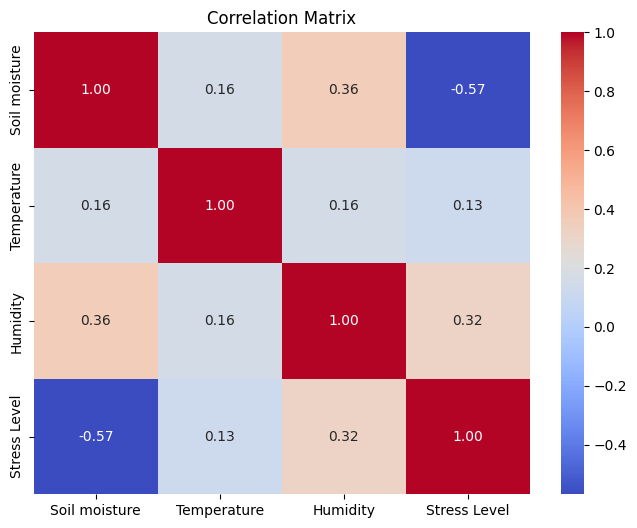

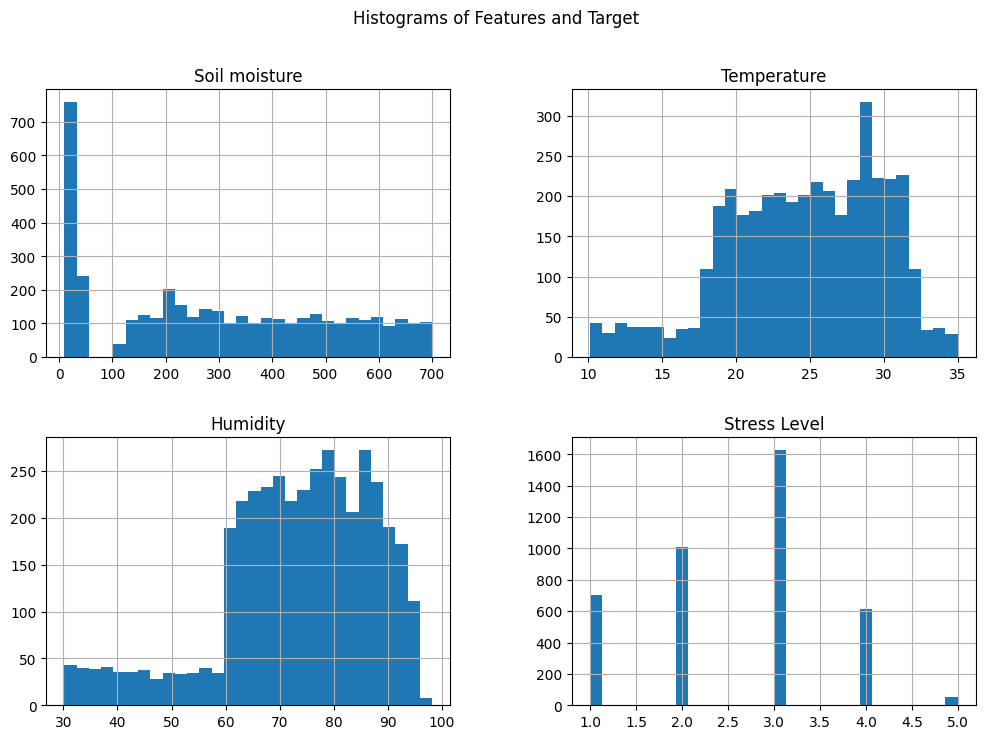

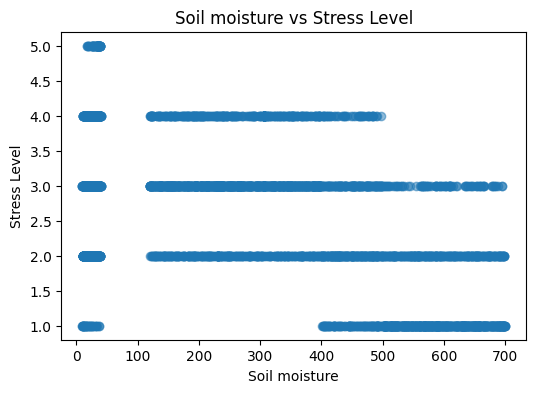

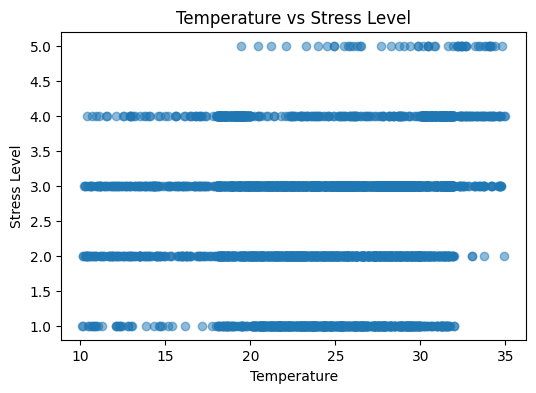

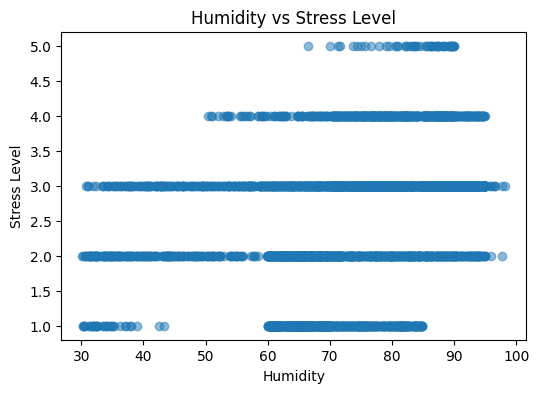


Starting grid search for RandomForest hyperparameters:


Grid Search Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:23<00:00,  1.15it/s]



Best hyperparameters found:
{'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Validation Accuracy with best hyperparameters: 0.9300

Test set performance:
Accuracy: 0.9250
Precision: 0.8383
Recall: 0.7864

Classification Report:
              precision    recall  f1-score   support

           1       0.99      1.00      0.99        70
           2       0.97      0.93      0.95       101
           3       0.92      0.93      0.93       163
           4       0.82      0.87      0.84        61
           5       0.50      0.20      0.29         5

    accuracy                           0.93       400
   macro avg       0.84      0.79      0.80       400
weighted avg       0.92      0.93      0.92       400



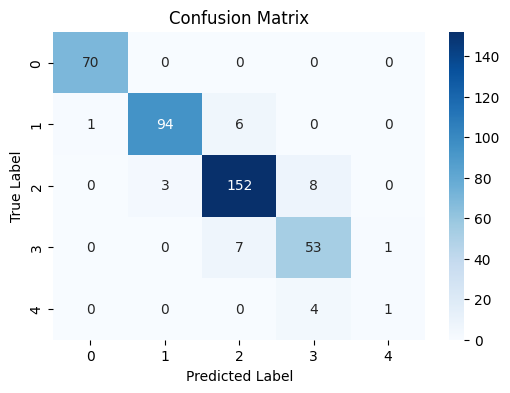


Best model saved as best_model.pth


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import joblib

from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

data = pd.read_csv("Dataset.csv")

Exploratory Data Analysis (EDA)
print("First 5 rows of the dataset:")
print(data.head())

print("\nStatistical summary:")
print(data.describe())

print("\nMissing values in each column:")
print(data.isnull().sum())

#Correlation Matrix
plt.figure(figsize=(8, 6))
corr = data.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Histograms for each variable
data.hist(bins=30, figsize=(12, 8))
plt.suptitle("Histograms of Features and Target")
plt.show()

# Scatter Plots: Each feature vs. Stress Level
features = ['Soil moisture', 'Temperature', 'Humidity']
for feature in features:
    plt.figure(figsize=(6, 4))
    plt.scatter(data[feature], data['Stress Level'], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel("Stress Level")
    plt.title(f"{feature} vs Stress Level")
    plt.show()


X = data[['Soil moisture', 'Temperature', 'Humidity']]
y = data['Stress Level'].astype(int)  # assuming the target is categorical

#  Split the dataset into train (80%), validation (10%), and test (10%) sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1111, random_state=42, stratify=y_train_val
)  


# Fine-tuning the RandomForest model with Grid Search using the training and validation sets
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid = list(ParameterGrid(param_grid))
best_params = None
best_accuracy = 0.0

print("\nStarting grid search for RandomForest hyperparameters:")
for params in tqdm(grid, desc="Grid Search Progress"):
    model = RandomForestClassifier(random_state=42, **params)
    model.fit(X_train, y_train)
    
    # Evaluate on the validation set
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    
    if acc > best_accuracy:
        best_accuracy = acc
        best_params = params

print("\nBest hyperparameters found:")
print(best_params)
print(f"Validation Accuracy with best hyperparameters: {best_accuracy:.4f}")

#Train the best model on the combined training + validation set
best_model = RandomForestClassifier(random_state=42, **best_params)
best_model.fit(X_train_val, y_train_val)

#Evaluate the model on the test set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='macro')
test_recall = recall_score(y_test, y_test_pred, average='macro')

print("\nTest set performance:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

#Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Save the best model as a .pth file
model_filename = "best_model.pth"
joblib.dump(best_model, model_filename)
print(f"\nBest model saved as {model_filename}")


In [13]:
import joblib
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

# Load the trained model 
best_model = joblib.load("best_model.pth")


initial_type = [('float_input', FloatTensorType([None, 3]))]

# Convert the model to ONNX format.
onnx_model = convert_sklearn(best_model, initial_types=initial_type)

# Save the ONNX model to a file.
onnx_filename = "best_model.onnx"
with open(onnx_filename, "wb") as f:
    f.write(onnx_model.SerializeToString())

print(f"Model successfully converted to ONNX and saved as {onnx_filename}")


Model successfully converted to ONNX and saved as best_model.onnx
